# Trabalho de Inteligência Artificial 2 - IESB

## Classificação de Sentimento em Twitters sobre os candidatos a presidência do Brasil - 2018

Este trabalho tem como objetivo analizar os sentimentos de twitters realizados sobre os candidatos a presidência do Brasil em 2018 entre textos com mensagens positivas ou negativas, e exemplificar em gráficos as analizes dos mesmos de forma individual.

### Candidatos a presidência 2018

+ Jair Bolsonaro (PSL) – 17
+ Fernando Haddad (PT) – 13
+ Ciro Gomes (PDT) – 12
+ Geraldo Alckmin (PSDB) – 45
+ Marina Silva (Rede) – 18
+ Alvaro Dias (Podemos) – 19
+ Henrique Meirelles (MDB) – 15
+ João Amoêdo (Novo) – 30
+ Guilherme Boulos (PSOL) – 50
+ José Maria Eymael (Democracia Cristã) – 27
+ Cabo Daciolo (Patriota) – 51
+ João Goulart Filho (PPL) – 54
+ Vera Lucia (PSTU) – 16

# Bibliotecas utilizadas no projeto

In [1]:
#from tweepy.streaming import StreamListener
#from tweepy import OAuthHandler, Stream
import time
from pprint import pprint
import json

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.lancaster import LancasterStemmer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
nltk.download('steaming')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akteotonio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading steaming: Package 'steaming' not found in
[nltk_data]     index


False

#  Web Crawler

Utilizando a biblioteca [Tweepy] [link1] e a autorização do Twitter para utilizar sua [API] [link2], foi realizado um web crawler, buscando localizar 1000 com os termos listados abaixo. O tempo de execução de cada busca está listado abaixo de cada termo.

O processador utilizado foi um Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz 2.40 GHz.

#### Termos:

+ 'Bolsonaro'
    * inicio: 1539456861.4597087
    * fim: 1539456958.9965942
    * total: 97.53688549995422
+ 'Haddad'
    * inicio: 1539456613.1283784
    * fim:    1539456791.6778507
    * total:  178.54947233200073
+ 'Ciro'
    * inicio: 1539456323.9065177
    * fim: 1539458030.606718
    * total: 1706.7002003192902
+ 'Alckmin'
    * inicio: 1539458055.8657103
    * fim: 1539461812.2720942
    * total: 3756.4063839912415
+ 'Marina Silva'
+ 'Alvaro Dias'
+ 'Meirelles'
+ 'Amoêdo'
+ 'Boulos'
    * inicio: 1539462744.8071775
    * fim: 1539465263.4699695
    * total: 2518.662791967392
+ 'Eymael'
+ 'Daciolo'
+ 'Goulart'
+ 'Vera Lucia'

##### OBS: O código utilizado para realizar o crawler está localizado abaixo

[link1]: https://github.com/tweepy/tweepy
[link2]: https://developer.twitter.com

In [7]:
# Variaveis de permição concedidas pelo Twitter à desenvolvedores
access_token = "" 
access_token_secret = ""
consumer_key = ""
consumer_secret = ""

# Termo que será crawleado
candidato = ""

# Classe que herda de StreamListener para realizar o Crawler
class StdoutListener(StreamListener):
	raw_data = {'text':[], 'candidato':[]}
	def on_data(self, data):
		try:
            # Cria duas colunas no dataset: Text e Candidato
			self.raw_data['text'].append(json.loads(data)['text'])
			self.raw_data['candidato'].append(candidato)
            # Caso já tenham sido capturadas 10000 twitters, o csv é salvo no diretorio indicado
			if len(self.raw_data['text']) == 1000:
				pprint(self.raw_data)
				df = pd.DataFrame(self.raw_data, columns = ['candidato', 'text'])
				df.to_csv(candidato+'.csv')
			return True
		except BaseException as e:
			print(str(e))
			time.sleep(5)

	def on_error(self, status):
		print(status)

if __name__ == "__main__":
	twiteer = StdoutListener() # Instância do Objeto
    # Inserindo credênciais de autorização
	auth = OAuthHandler(consumer_key, consumer_secret) 
	auth.set_access_token(access_token, access_token_secret)
	stream = Stream(auth, twiteer) # Instânciando objeto de crawler
	stream.filter(track=[candidato]) # Definindo termo que será utilizado para pesquisa

# Leitura do dataset

Utilizando o dataset disponivel [neste link] [link1], que possui 99989 twitters, tentamos realizar o treinamento de nossa rede neural.

O dataset possui três colunas: 

#### Colunas:

+ 'ItemID'
    * Representa o id da linha. Este foi retirado no momento de leitura
+ 'Sentiment'
    * Este define o sentimento do twitter entre 0(NEGATIVO) ou 1(POSITIVO)
+ 'SentimentText'
    * Aqui encontra-se o texto do twitter em si
    
|ItemID|Sentiment|SentimentText|
|------|------|------|
|1  |0  |text  |
|2  |1  |text  | 
|3  |0  |text  | 
|...  |...  |...  | 

[link1]: https://www.kaggle.com/c/twitter-sentiment-analysis2

In [3]:
import pandas as pd
data = pd.read_csv('train.csv', encoding='latin-1')
data = data.drop(['ItemID'], axis=1)
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [4]:
data.Sentiment.value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

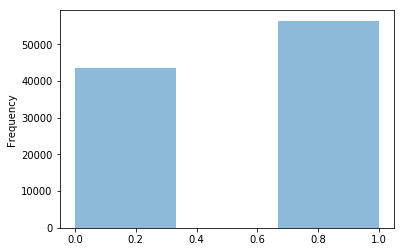

In [5]:
data.Sentiment.plot.hist(bins=3, alpha=0.5)

In [6]:
data.shape

(99989, 2)

In [7]:
print('Total de textos a serem analizados:', data.SentimentText.value_counts().size)
print('Total de termos sem repetição:', data.SentimentText.unique().size)

Total de textos a serem analizados: 99989
Total de termos sem repetição: 99989


# Tratamento dos dados

Nesta etapa utilizaremos as bibliotecas re e nltk do python para tratar nossos dados antes de utiliza-los em nossa rede neural, seguindo diversas etapas afim de melhorar nossa acurácia.

Ápos o tratamento realizaremos a tokenização de nossos twitters com keras, transformando-os em valores numericos, para efetivamente serem jogados na rede neural.

#### Etapas de tratamento:

+ Palavras com caracteres minusculos
+ Remoções:
    * Pontuação
    * Caracteres repetidos
    * StopWords
    * Nomes próprios
    * Valores numericos
    * Links, emails e URLs
    * Usernames
+ Tokenization
+ Steamization ou Lammetization
+ Concatenação

In [8]:
def words_to_lower(data):
    return data.SentimentText.apply(lambda x: x.lower())

def remove_username(data):
    return data.SentimentText.apply(lambda x: re.sub(r'@[\w\.-]+','',x))

def remove_email(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[\w\.-]+@[\w\.-]+','',x))

def remove_url(data):
    return data.SentimentText.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*','',x))

def remove_number(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[0-9]','',x))

def remove_pontuation(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[^a-zA-z\s]','',x))

def remove_repeated_character(data):
    return data.SentimentText.apply(lambda x: re.sub(r"(\w)\1*", r'\1', x))

def tokenizer(data):
    return data.SentimentText.apply(lambda x: nltk.word_tokenize(x))

def remove_stopword(data):
    stop_words = set(stopwords.words('english'))
    return data.SentimentText.apply(lambda x: [j for j in x if not j in stop_words])

def stemming(data):
    stem = LancasterStemmer()
    return data.SentimentText.apply(lambda x: [stem.stem(j) for j in x])

def concat(data):
    return data.SentimentText.apply(lambda x: " ".join(x))

In [9]:
data.SentimentText = words_to_lower(data)
data.SentimentText = remove_username(data)
data.SentimentText = remove_number(data)
data.SentimentText = remove_pontuation(data)
data.SentimentText = remove_repeated_character(data)
data.SentimentText = tokenizer(data)
data.SentimentText = remove_stopword(data)
data.SentimentText = stemming(data)
data.SentimentText = concat(data)

In [10]:
data.head()

,Sentiment,SentimentText
0,0,sad apl friend
1,0,mis new mon trail
2,1,omg already
3,0,omgag im im gun cry iv ben dent sint supos get...
4,0,think mi bf che t_t


In [ ]:
#data = data[data.sentiment != "Neutral"]
#data['SentimentText'] = data['SentimentText'].apply(lambda x: x.lower())
#data['SentimentText'] = data['SentimentText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

#print(data[ data['Sentiment'] == 1].size)
#print(data[ data['Sentiment'] == 0].size)

#for idx,row in data.iterrows():
#    row[0] = row[0].replace('rt',' ')

In [11]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data.SentimentText.values)
X = tokenizer.texts_to_sequences(data.SentimentText.values)
X = pad_sequences(X)

In [12]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 53, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


#### Dense 
implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

#### Dropout 
consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

#### lambda 
Wraps arbitrary expression as a Layer object.

#### Batch normalization layer (Ioffe and Szegedy, 2014).
Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

#### ReLU 
The Rectified Linear Unit computes the function f(x)=max(0,x)f(x)=max(0,x). In other words, the activation is simply thresholded at zero (see image above on the left).

In [47]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(66992, 53) (66992, 2)
(32997, 53) (32997, 2)


In [55]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 1)

Epoch 1/7
66992/66992 [==============================] - 251s 4ms/step - loss: 0.4409 - acc: 0.7885
Epoch 2/7
66992/66992 [==============================] - 250s 4ms/step - loss: 0.4303 - acc: 0.7938
Epoch 3/7
66992/66992 [==============================] - 238s 4ms/step - loss: 0.4203 - acc: 0.8003
Epoch 4/7
66992/66992 [==============================] - 242s 4ms/step - loss: 0.4082 - acc: 0.8069
Epoch 5/7
66992/66992 [==============================] - 266s 4ms/step - loss: 0.3980 - acc: 0.8146
Epoch 6/7
66992/66992 [==============================] - 236s 4ms/step - loss: 0.3876 - acc: 0.8174ETA: 0s - loss: 0.3876 - acc: 0.817
Epoch 7/7
66992/66992 [==============================] - 241s 4ms/step - loss: 0.3758 - acc: 0.8248


In [95]:
def plt_history(name, color, index):
    plt.figure()
    plt.title('Model '+name)
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.plot(history.epoch, np.array(history.history[index]), color=color)

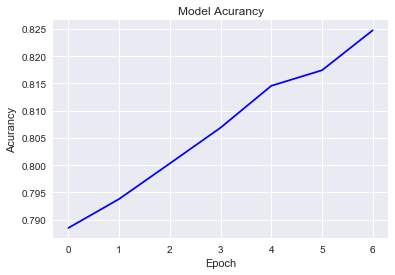

In [97]:
plt_history("Acurancy", "blue", "acc")

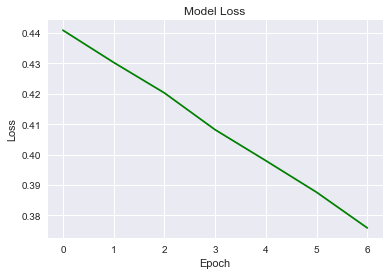

In [98]:
plt_history("Loss", "green", "loss")

In [123]:
test_predictions = model.predict(X_test)

In [124]:
test_predictions

array([[0.44495124, 0.5550488 ],
       [0.00523237, 0.99476767],
       [0.9880918 , 0.01190824],
       ...,
       [0.9842551 , 0.01574489],
       [0.8503505 , 0.14964949],
       [0.5983476 , 0.40165237]], dtype=float32)

In [125]:
model.save('twitter_sentimental_analyze.h5')

In [126]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.61
acc: 0.73


In [127]:
predicted = model.predict(X_test)
predict = list()
test_labels = list()
for value in predicted:
    predict.append(0 if value[0] < value[1] else 1)
for value in Y_test:
    test_labels.append(0 if value[0] < value[1] else 1)

In [128]:
Y_test

array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

[[13898  3762]
 [ 4686  9151]]


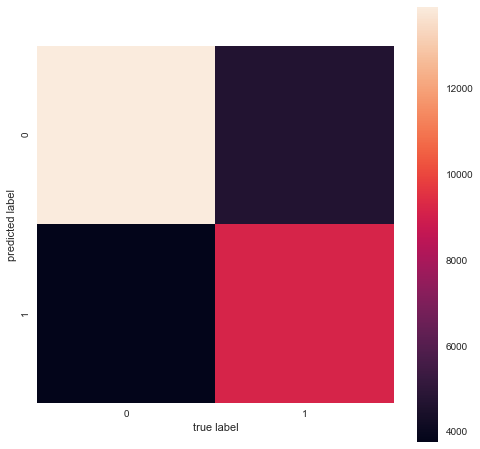

In [129]:
%matplotlib inline
mat = confusion_matrix(test_labels, predict)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
# annot=True,
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
print(mat)
plt.show()

In [130]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 75.89388696655132 %
neg_acc 66.35071090047393 %


In [135]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=53, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  320   30 1234 1149 1234  320   30]]
negative
